# SQUID - Collection of recommender systems

<img src="https://github.com/tesemnikov-av/graph-rec-sys/blob/main/pics/squid.png?raw=true" width="200"/>

> Out there, I don't stand a chance. I do in here.

* Content-based filtering
    + Graphs 
        - Neighbors by Graph
        - Embedding with Node2Vec
    + Text Description
        - HuggingFace Transformers
        - Topic Modeling with Spacy and LDA
* Collaborative filtering
    - SVD
    - Implicit
    - LightFM
   
* CatBoost
*  FAISS
* Metrics and Validation
* Popular Content

# Installing Node2Vec, Download Datasets

In [ ]:
!wget --quiet https://raw.githubusercontent.com/tesemnikov-av/graph-rec-sys/main/datasets/kinopoisk-top250.csv
!pip --quiet install node2vec

In [ ]:
import pandas as pd
import networkx as nx
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from node2vec import Node2Vec

# Recommendations based on neighbors in a graph

Load Data

In [ ]:
kinopoisk_df = pd.read_csv('kinopoisk-top250.csv')[['movie','actors', 'year', 'country', 'director']]

In [ ]:
kinopoisk_df.head()

movie  ...                       director
0  Побег из Шоушенка   ...                 Фрэнк Дарабонт
1       Зеленая миля   ...                 Фрэнк Дарабонт
2       Форрест Гамп   ...                 Роберт Земекис
3    Список Шиндлера   ...                Стивен Спилберг
4                1+1   ...   Оливье Накаш;  Эрик Толедано

[5 rows x 5 columns]

In [ ]:
films = kinopoisk_df['movie'].values

Create Graph from Pandas DataFrame

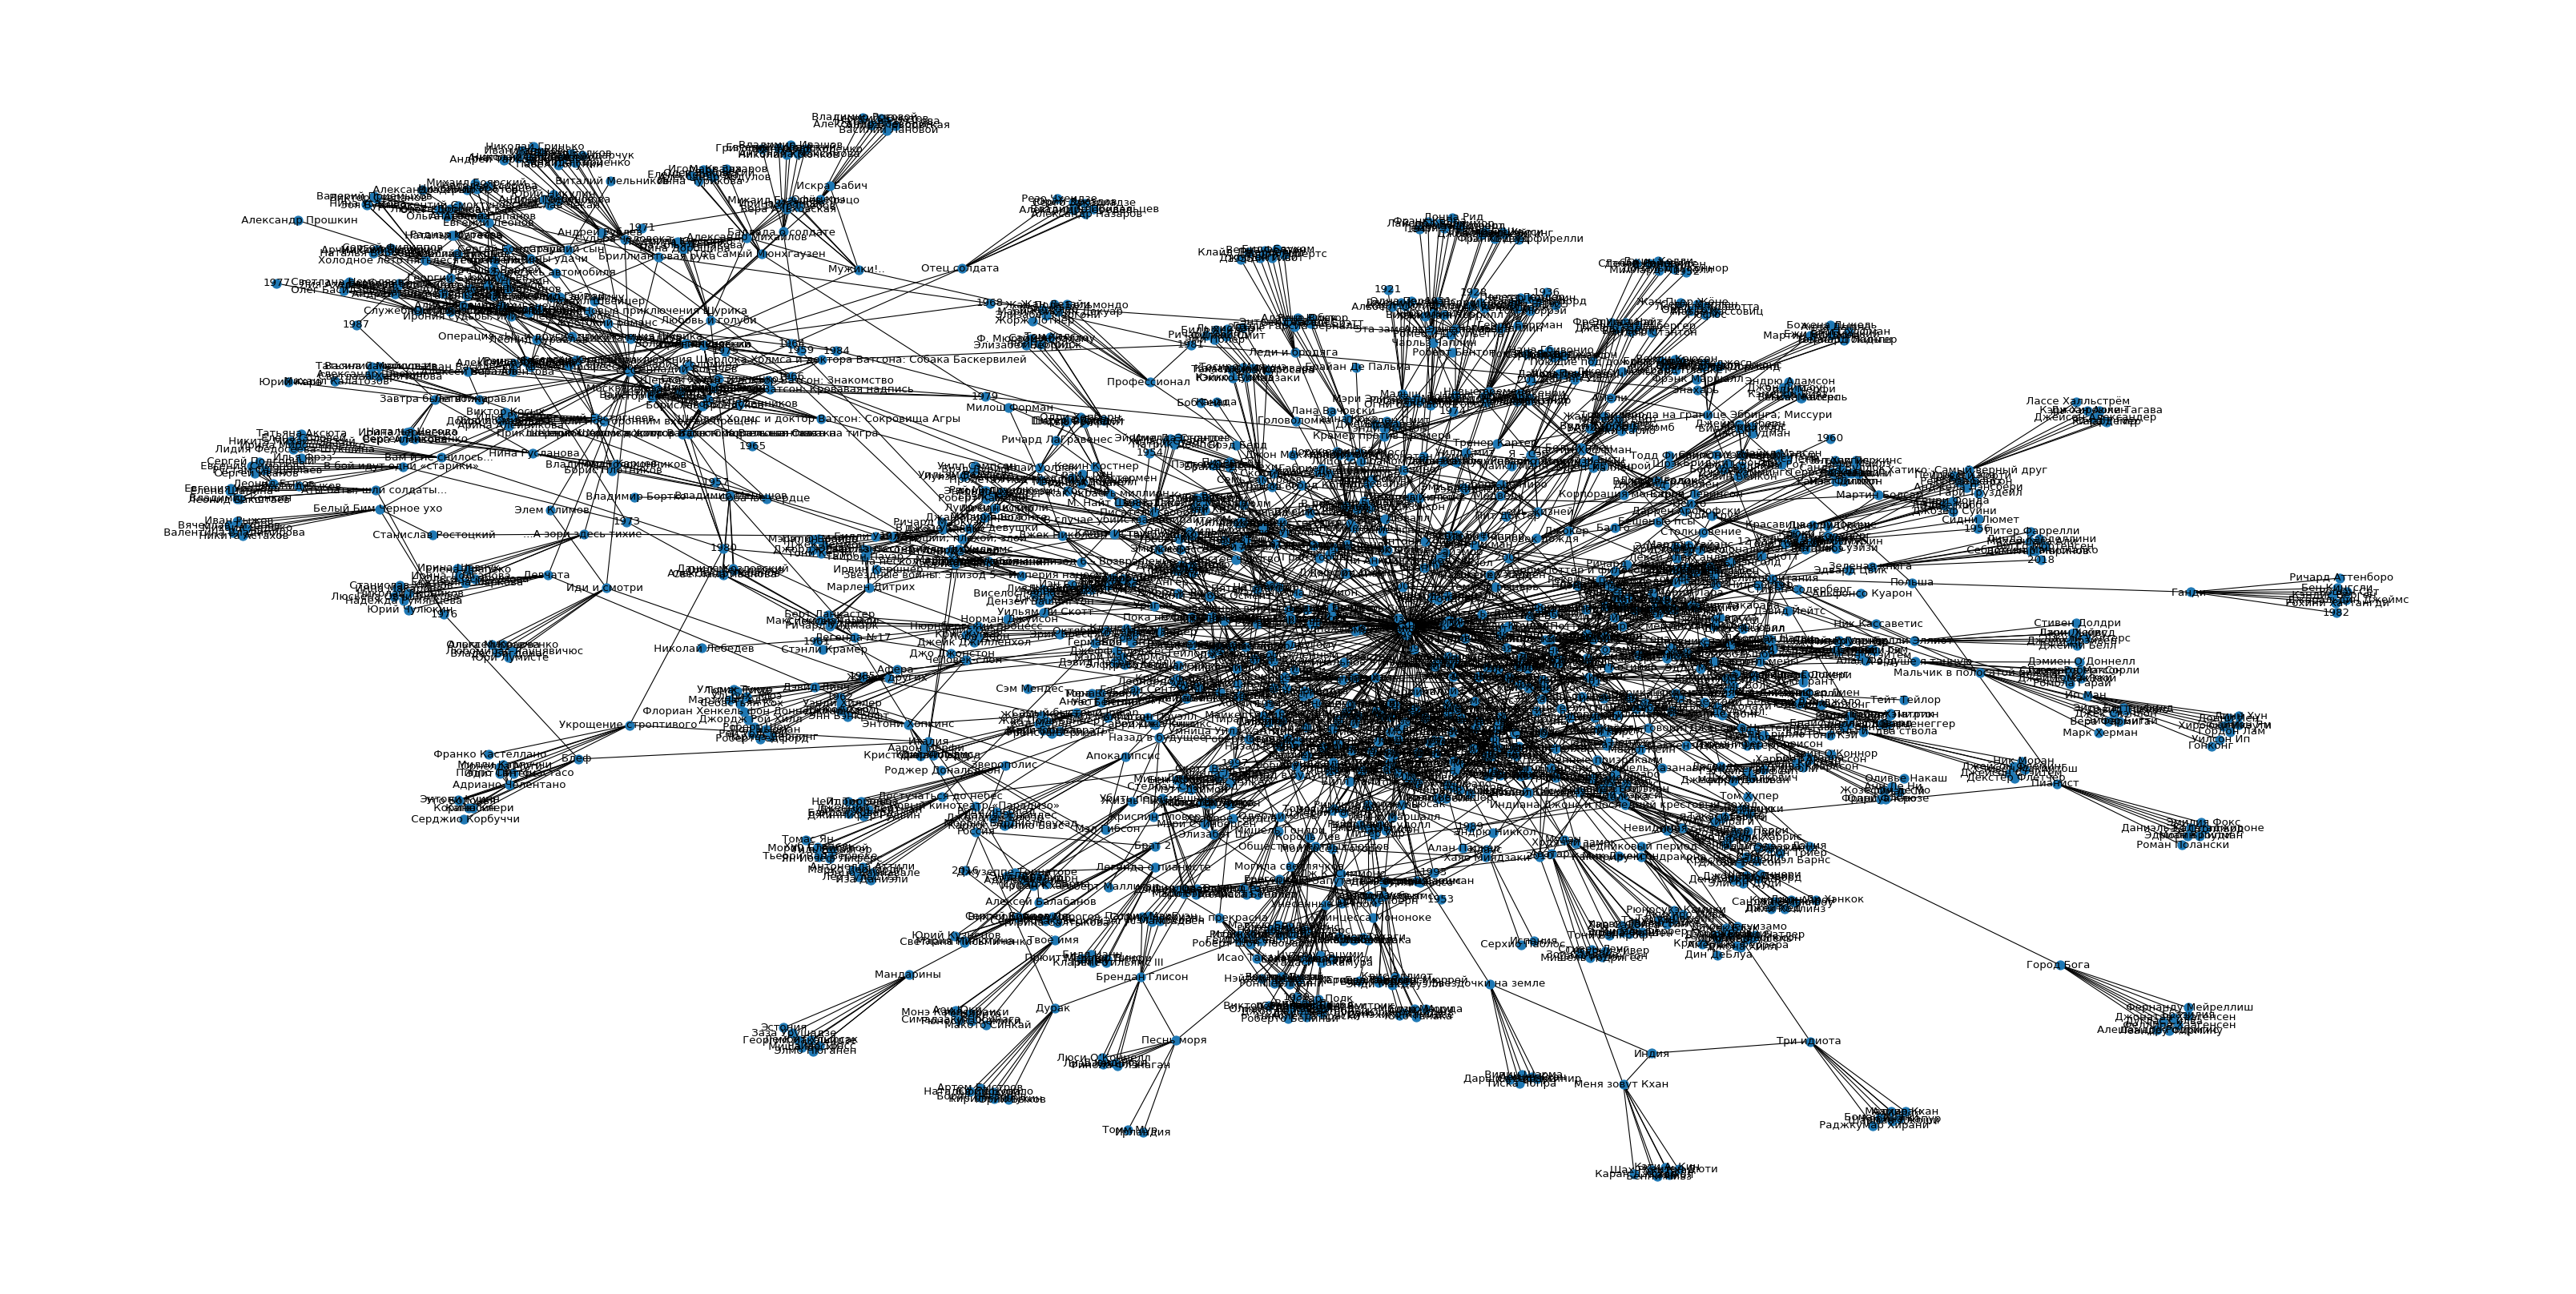

In [ ]:
edges = []
for index, row in kinopoisk_df.iterrows():
    movie, actors, year, country, director = row
    actors = actors.split(';')
    director = director.split(';')[0]
    
    for actors_one in actors:
        for actors_two in actors:
            if actors_one != actors_two:
                edges.append((actors_one, actors_two))
                edges.append((actors_one, movie))
                edges.append((director, movie))
                edges.append((country, movie))
                edges.append((year, movie))

kinopoiskGraph = nx.Graph()
kinopoiskGraph.add_edges_from(edges)

figure(figsize=(40, 20), dpi=80)
nx.draw(kinopoiskGraph, with_labels = True, node_size=100)

In [ ]:
def graph_neighbors(film_name):
    
    recomendation = []
    
    for neighbor_one in kinopoiskGraph.neighbors(film_name):
        for neighbor_two in kinopoiskGraph.neighbors(neighbor_one):
            if neighbor_two in films:
                if neighbor_two != film_name:
                    recomendation.append((neighbor_two, neighbor_one))

    return pd.DataFrame(recomendation, columns=['recomendation', 'relation'])

The function returns the recommends movies and interprets its choice

In [ ]:
recomendation_1 = graph_neighbors('Криминальное чтиво ')

In [ ]:
# All recomendation
recomendation_1

recomendation            relation
0                       Джанго освобожденный    Квентин Тарантино
1                                Бешеные псы    Квентин Тарантино
2                          Побег из Шоушенка                  США
3                               Зеленая миля                  США
4                               Форрест Гамп                  США
..                                        ...                 ...
151                               Король Лев                 1994
152                     Джанго освобожденный    Сэмюэл Л. Джексон
153  Звёздные войны: Эпизод 3 – Месть Ситхов    Сэмюэл Л. Джексон
154                 Счастливое число Слевина          Брюс Уиллис
155                                  Гаттака           Ума Турман

[156 rows x 2 columns]

In [ ]:
# Movie recommendations without regard to country
recomendation_1[~recomendation_1.relation.isin(kinopoisk_df['country'].values)]

recomendation            relation
0                       Джанго освобожденный    Квентин Тарантино
1                                Бешеные псы    Квентин Тарантино
148                        Побег из Шоушенка                 1994
149                             Форрест Гамп                 1994
150                                     Леон                 1994
151                               Король Лев                 1994
152                     Джанго освобожденный    Сэмюэл Л. Джексон
153  Звёздные войны: Эпизод 3 – Месть Ситхов    Сэмюэл Л. Джексон
154                 Счастливое число Слевина          Брюс Уиллис
155                                  Гаттака           Ума Турман

# Recommendations with graph Node2vec embedding 

<img src="https://github.com/tesemnikov-av/graph-rec-sys/blob/main/pics/bear.png?raw=true" width="200"/>

In [ ]:
node2vec = Node2Vec(kinopoiskGraph, dimensions=16, walk_length=4, num_walks=100, workers=4)
model = node2vec.fit(window=4)

Computing transition probabilities:   0%|          | 0/1518 [00:00<?, ?it/s]

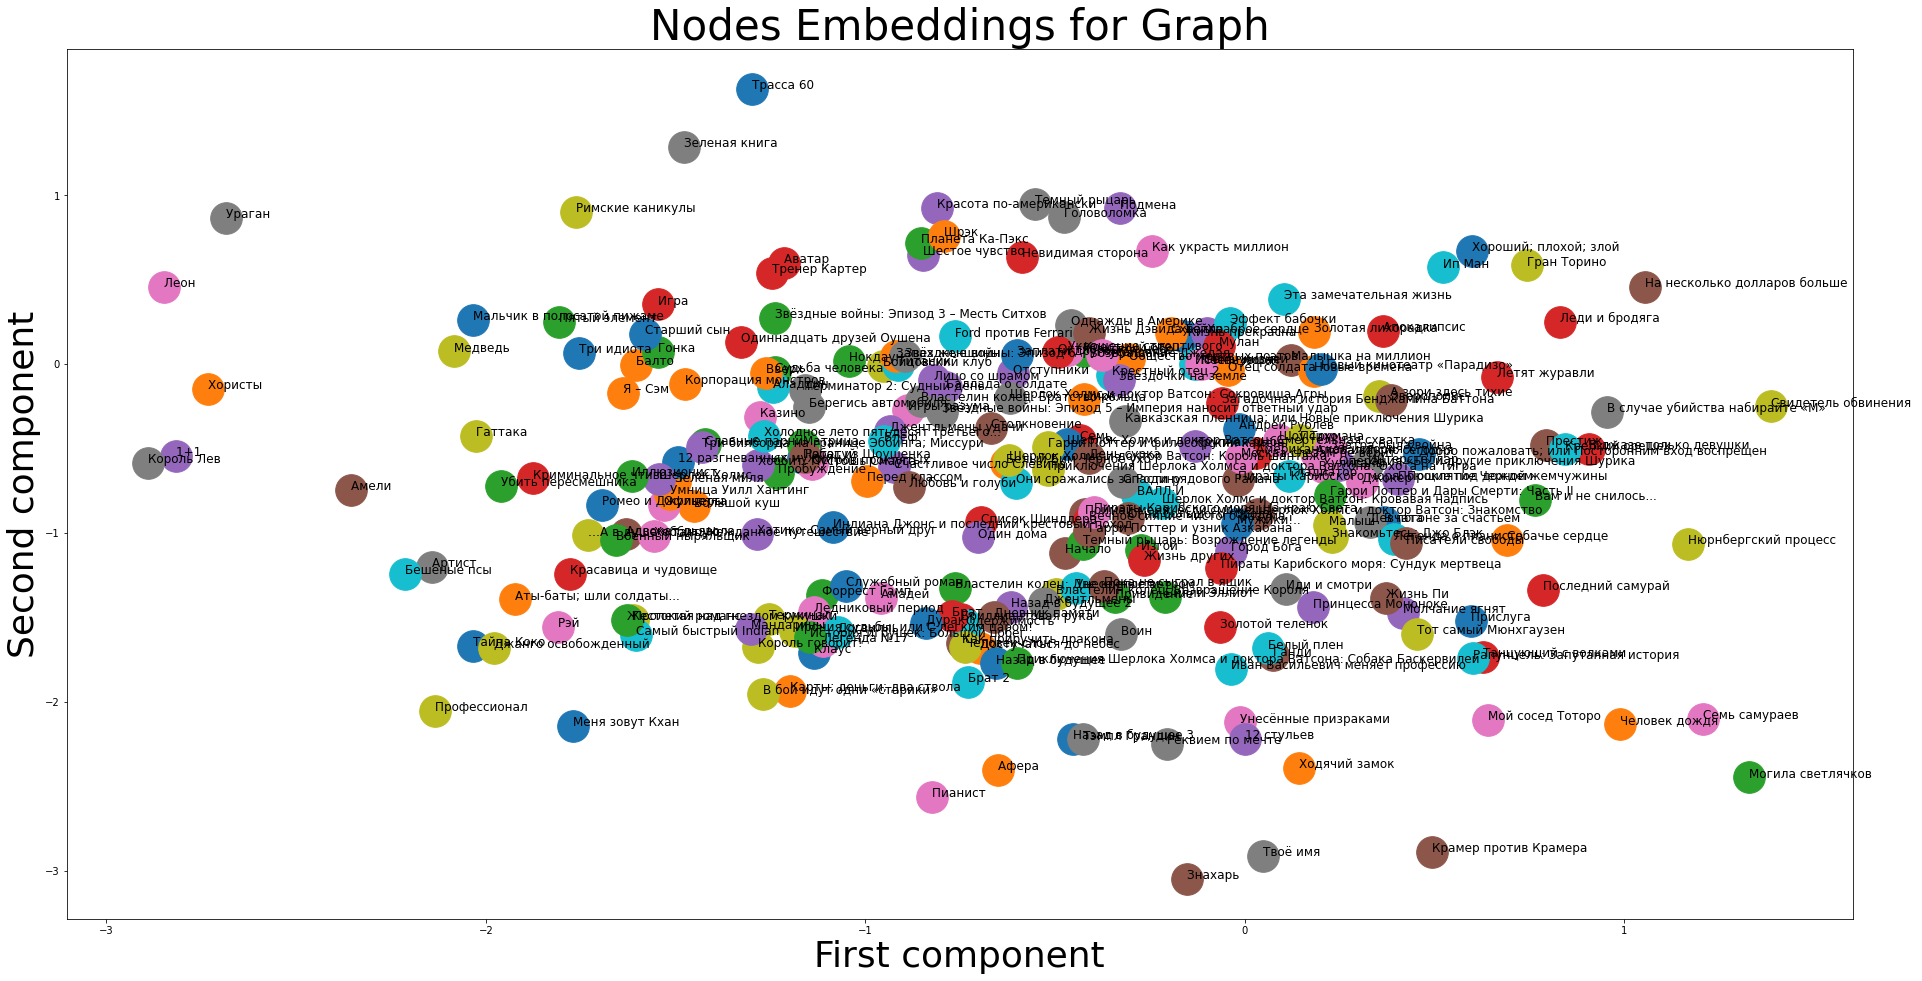

In [ ]:
fig, ax = plt.subplots(figsize=(32, 16))

ax.set_title('Nodes Embeddings for Graph', {'fontsize' : 42})
ax.set_xlabel('First component', {'fontsize' : 36})
ax.set_ylabel('Second component', {'fontsize' : 36})

for film in kinopoiskGraph.nodes():
    if film in films:
        v = model.wv.get_vector(str(film))
        ax.scatter(v[0], v[1], s=1000)
        ax.annotate(str(film), (v[0],v[1]), fontsize=12)

In [ ]:
def graph_embeding(film_name, topn=40):

    recomendation_2 = []
    
    for recomendation in model.wv.most_similar(film_name, topn=topn):
        if recomendation[0] in films:
            recomendation_2.append(recomendation)

    return pd.DataFrame(recomendation_2, columns=['recomendation', 'similarity'])

In [ ]:
graph_embeding('Криминальное чтиво ')

recomendation  similarity
0                     Джанго освобожденный     0.853072
1  Звёздные войны: Эпизод 3 – Месть Ситхов     0.809230
2                                  Гаттака     0.766077
3                                      Рэй     0.761418
4                              Бешеные псы     0.733941
5                 Счастливое число Слевина     0.694098
6                           Дневник памяти     0.691075
7             Вечное сияние чистого разума     0.680806
8                                 Терминал     0.675464

# Recommendations based on movie description HuggingFace and FAISS

<img src="https://github.com/tesemnikov-av/graph-rec-sys/blob/main/pics/hoodie.png?raw=true" width="200"/>

In [ ]:
kinopoisk_df = pd.read_csv('kinopoisk-top250.csv')[['movie','overview']]

In [ ]:
kinopoisk_df.head(5)

movie                                           overview
0  Побег из Шоушенка   Бухгалтер Энди Дюфрейн обвинён в убийстве собс...
1       Зеленая миля   Пол Эджкомб — начальник блока смертников в тюр...
2       Форрест Гамп   От лица главного героя Форреста Гампа; слабоум...
3    Список Шиндлера   Фильм рассказывает реальную историю загадочног...
4                1+1   Пострадав в результате несчастного случая; бог...

In [ ]:
!pip --quiet install transformers sentencepiece

     |████████████████████████████████| 3.4 MB 13.5 MB/s 
     |████████████████████████████████| 1.2 MB 74.9 MB/s 
     |████████████████████████████████| 895 kB 71.5 MB/s 
     |████████████████████████████████| 67 kB 4.6 MB/s 
     |████████████████████████████████| 3.3 MB 63.5 MB/s 
     |████████████████████████████████| 596 kB 79.0 MB/s 


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny")
model = AutoModel.from_pretrained("cointegrated/rubert-tiny")


def embed_bert_cls(text, model, tokenizer):
    t = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**{k: v.to(model.device) for k, v in t.items()})
    embeddings = model_output.last_hidden_state[:, 0, :]
    embeddings = torch.nn.functional.normalize(embeddings)
    return embeddings[0].cpu().numpy()

Downloading:   0%|          | 0.00/341 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/632 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/235k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/457k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/45.5M [00:00<?, ?B/s]

Some weights of the model checkpoint at cointegrated/rubert-tiny were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
kinopoisk_df['embedding'] = kinopoisk_df['overview'].apply(lambda x: embed_bert_cls(x, model, tokenizer))

In [ ]:
kinopoisk_df.head(5)

movie  ...                                          embedding
0  Побег из Шоушенка   ...  [0.02413234, 0.010032795, -0.0020337496, -0.05...
1       Зеленая миля   ...  [0.028491205, 0.03074856, -0.040249247, -0.036...
2       Форрест Гамп   ...  [0.06095415, 0.014614512, -0.01622845, -0.0627...
3    Список Шиндлера   ...  [0.05812029, -0.06500672, -0.073797904, -0.066...
4                1+1   ...  [0.033448182, 0.0068250406, -0.025532678, -0.0...

[5 rows x 3 columns]

In [ ]:
!pip --quiet install faiss
!pip --quiet install faiss-cpu 

     |████████████████████████████████| 4.7 MB 15.8 MB/s 
     |████████████████████████████████| 8.6 MB 13.1 MB/s 


We reduce the dimension of embedinogs and group them into clusters using FAISS to quickly find similar elements

In [ ]:
import faiss 

DIM = 312

index = faiss.index_factory(DIM, "PCA80,Flat")
embeddings = kinopoisk_df[['embedding']].to_numpy()
embeddings = [emb[0] for emb in embeddings]
embeddings = np.array(embeddings)

index.train(embeddings)
index.add(embeddings)
D, I = index.search(embeddings, 3) 

kinopoisk_dict = kinopoisk_df['movie'].to_dict()
faiss_rec = pd.DataFrame(I, index=kinopoisk_df['movie'].values, columns=['self','rec1','rec2'])[['rec1', 'rec2']]

faiss_rec['rec1'] = faiss_rec['rec1'].apply(lambda x: kinopoisk_dict[x])
faiss_rec['rec2'] = faiss_rec['rec2'].apply(lambda x: kinopoisk_dict[x])

In [ ]:
faiss_rec.loc[['Иван Васильевич меняет профессию ']]

rec1         rec2
Иван Васильевич меняет профессию   Бриллиантовая рука   12 стульев